## Simpler example of how to rasterize a polygon feature
for example, to create an ibound array

In [1]:
import sys
import glob
sys.path += glob.glob('/Users/aleaf/Documents/GitHub/*')
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import mapping
import rasterio
from rasterio import features
from rasterio import Affine
from flopy.utils import SpatialReference
from GISio import shp2df, get_proj4

% matplotlib inline

In [2]:
# path to shapefile of interest
shapefile = '/Users/aleaf/Documents/MAP/shps/MERAS_Extent/MERAS_Extent.shp'

# model grid info
xul, yul = 178389., 1604780.
rotation = 0
dx = 5280 *.3048 # cell spacing in meters
dy = 5280 *.3048
nrow, ncol = 414, 394 # number of rows and columns

### read in shapefile
feature is initially read in as a `shapely` object

In [3]:
df = shp2df(shapefile)
df.geometry[0].bounds


reading /Users/aleaf/Documents/MAP/shps/MERAS_Extent/MERAS_Extent.shp...
--> building dataframe... (may take a while for large shapefiles)


(179844.68794184283, 939365.0161827195, 811872.8150165773, 1603420.719445296)

### convert feature to GeoJSON

In [4]:
feature_gj = mapping(df.geometry[0])

### create a list of (feature, number) tuples
the number for each feature will be assigned to the intersecting raster cells

In [5]:
shapes = [(feature_gj, 1)]

### create a `rasterio.Affine` reference for the grid

In [6]:
trans = Affine(dx, 0, xul, 
               0, -dy, yul)

### rasterize the features to a numpy array

In [7]:
result = features.rasterize(shapes, out_shape=(nrow, ncol), transform=trans)

In [8]:
result

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

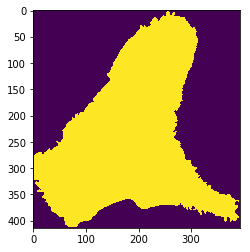

In [9]:
plt.imshow(result)

### get the proj4 string for the shapefile

In [10]:
proj4 = get_proj4(shapefile)
proj4

'+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs '

### export to GeoTiff

In [11]:
meta = {'count': 1,
        'dtype': result.dtype,
        'driver': 'GTiff',
        'height': result.shape[0],
        'width': result.shape[1],
        'crs': proj4,
        'transform': trans}

with rasterio.open('export/ibound.tif', 'w', **meta) as dest:
    dest.write(result, 1)